# Vision Transformer with Pytorch (CPU)

# Validate

In [22]:
import torch
from transformers import ViTForImageClassification
import pytorch_lightning as pl
import torch.nn as nn

In [23]:
class Modelo(pl.LightningModule):
    def __init__(self):
        super(Modelo, self).__init__()
        # Carregar um modelo pré-treinado
        self.model =  ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=1, ignore_mismatched_sizes=True)
        
        # Congelar os pesos das camadas pré-treinadas
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Substituir a última camada para um problema binário
        self.model.classifier = nn.Sequential(
            nn.Linear(self.model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        self.sigmoid = nn.Sigmoid()

        # Função de perda
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        logits = self.model(x).logits
        return logits

    def training_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels.float().unsqueeze(1)) 
        probabilities = self.sigmoid(logits)
        predicted = torch.round(probabilities)
        accuracy = (predicted == labels.unsqueeze(1)).float().mean()
                
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy', accuracy, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        loss = self.criterion(logits, labels.float().unsqueeze(1)) 
        probabilities = self.sigmoid(logits)
        predicted = torch.round(probabilities)
        accuracy = (predicted == labels.unsqueeze(1)).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', accuracy, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer
      


In [24]:
# Instancie o modelo
model = Modelo()

# Carregue o estado do modelo salvo
model.load_state_dict(torch.load('./models/modelo_vit_gpu.pth'))
model.eval() 

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo(
  (model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermed

In [58]:
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
import os

def avaliarModelo(path_paste):
  all_files_and_dirs = os.listdir(path_paste)

  # Filtra apenas os arquivos
  files = [f for f in all_files_and_dirs if os.path.isfile(os.path.join(path_paste, f))]

  for i, file in enumerate(files):
    
    
    image_path = f"{path_paste}/{file}"
    image = Image.open(image_path).convert('RGB')

    # Transforme a imagem
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image_tensor = transform(image).unsqueeze(0)  # Adicione uma dimensão para o batch

    # Certifique-se de que o modelo está em modo de avaliação
    model.eval()

    with torch.no_grad():
        # Faça a previsão
        output = model(image_tensor)
        probabilities = torch.sigmoid(output)
        prediction = torch.round(probabilities).item()

    # Exibir a imagem
    plt.imshow(image)
    plt.axis('off')  # Não exibir os eixos
    plt.title(f'Predicted class: {"Dog" if prediction == 1 else "Cat"}')
    plt.show()
    
    if i == 15:
      break


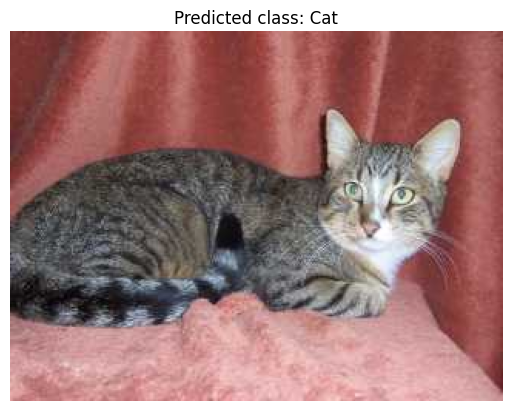

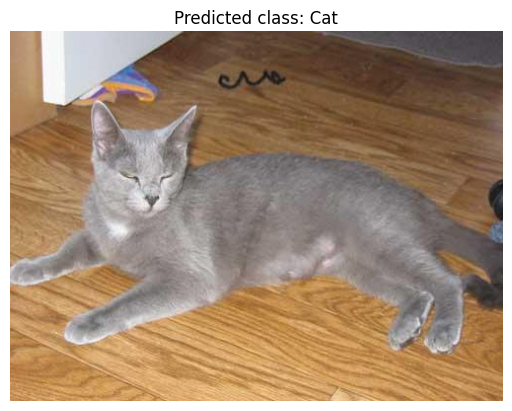

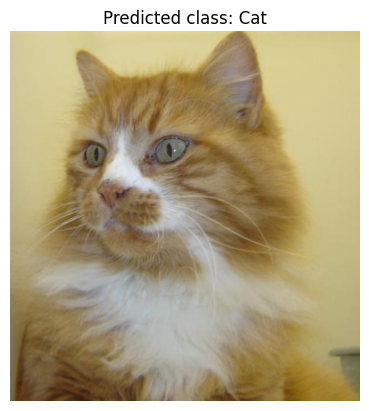

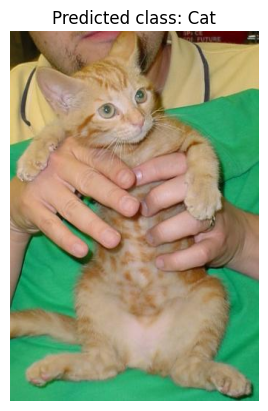

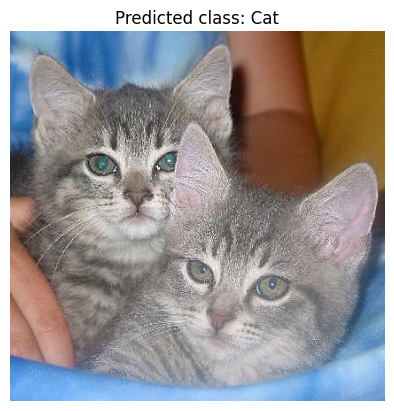

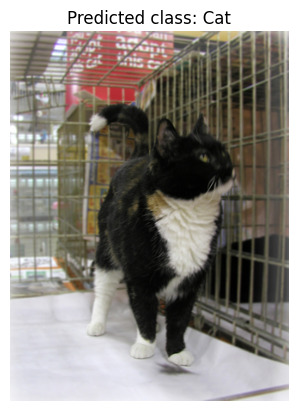

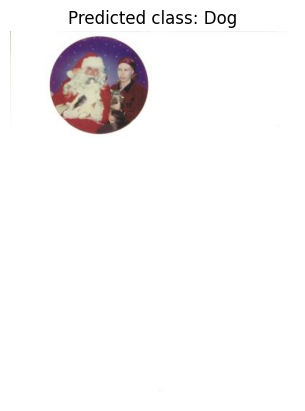

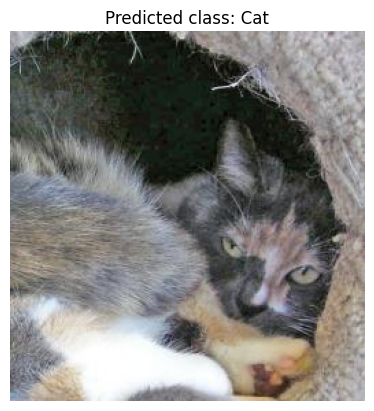

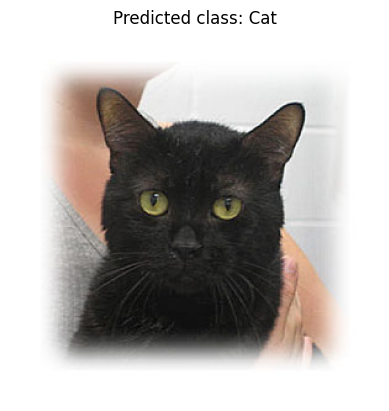

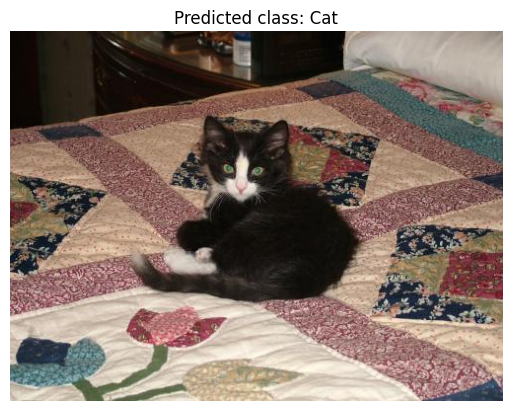

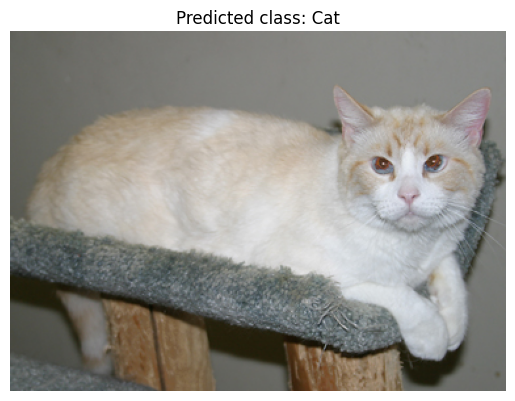

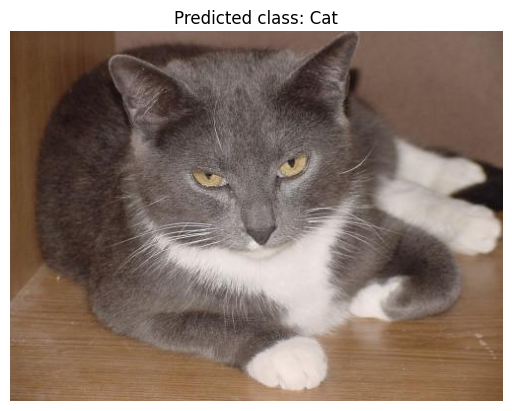

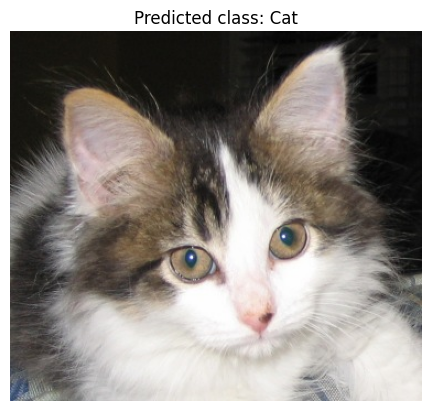

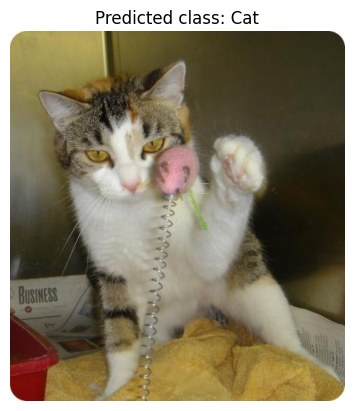

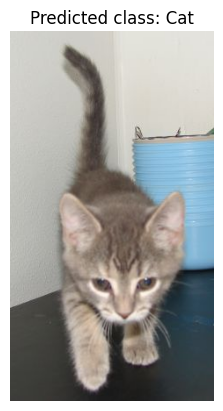

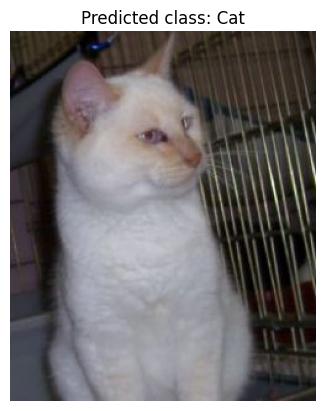

In [59]:
avaliarModelo("./data/dog_cat/dataset_treino_e_teste/test/Cat")

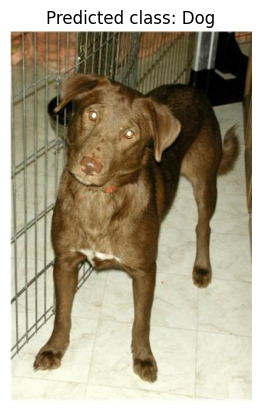

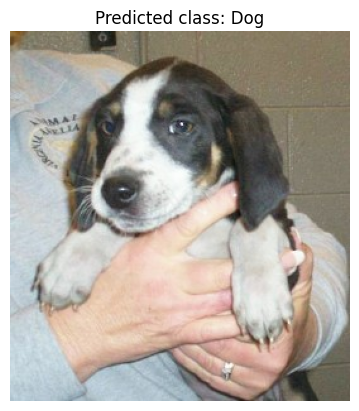

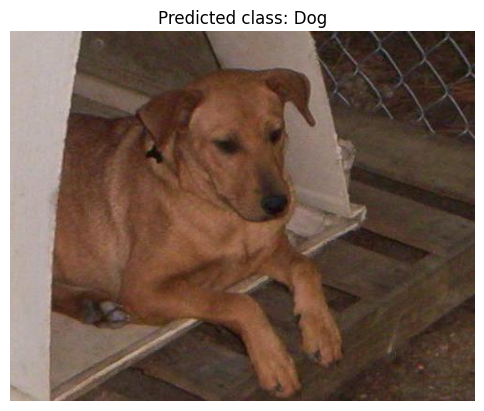

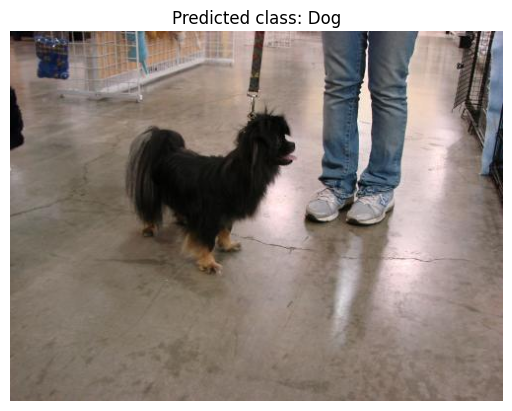

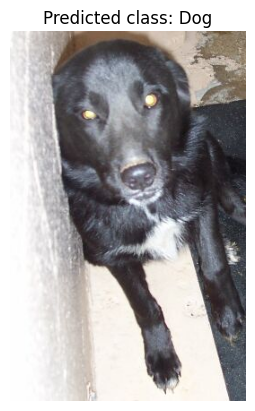

In [46]:
avaliarModelo("./data/dog_cat/dataset_treino_e_teste/test/Dog")